# Rating Prediction - Regression 

## 1. Imports 

In [85]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sentence_transformers import SentenceTransformer
from xgboost import XGBRegressor

## 2. Load data

In [86]:
project_root = Path.cwd().parent
DATA_DIR = Path(project_root / "data")

with open(DATA_DIR/"all_recipes_clean.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.head())
print(df.shape)

                                    title  \
0         Lasagnes végétariennes (facile)   
1            Hachis parmentier végétarien   
2             Curry de légumes végétarien   
3                    Hamburger Végétarien   
4  Tourte de Noël végétarienne de Coralie   

                                                 url  rating  \
0  https://www.marmiton.org/recettes/recette_lasa...     4.8   
1  https://www.marmiton.org/recettes/recette_hach...     4.6   
2  https://www.marmiton.org/recettes/recette_curr...     4.8   
3  https://www.marmiton.org/recettes/recette_hamb...     4.7   
4  https://www.marmiton.org/recettes/recette_tour...     4.6   

                                         ingredients  total_ecv  total_kcal  \
0  [{'ingredient_name': 'tomates', 'quantity': 20...   0.449643  242.400000   
1  [{'ingredient_name': 'poireau', 'quantity': 15...   0.269614  614.366667   
2  [{'ingredient_name': 'carotte', 'quantity': 40...   0.357829  224.000000   
3  [{'ingredient_name': 'oeu

## 3. Keep recipes with rating

In [87]:
recipes_with_rating = [
    r for r in data
    if r.get("rating") is not None and isinstance(r.get("rating"), (int, float)) and r.get("rating") > 0
]
print("Remaining recipes with rating:", len(recipes_with_rating))

df = pd.DataFrame(recipes_with_rating)
print(df.shape)

Remaining recipes with rating: 1693
(1693, 13)


## 4. Statistqiues descriptives du dataset

count    1693.000000
mean        4.395275
std         0.674459
min         1.000000
25%         4.200000
50%         4.600000
75%         4.800000
max         5.000000
Name: rating, dtype: float64
Proportion de 0 : 0.00%


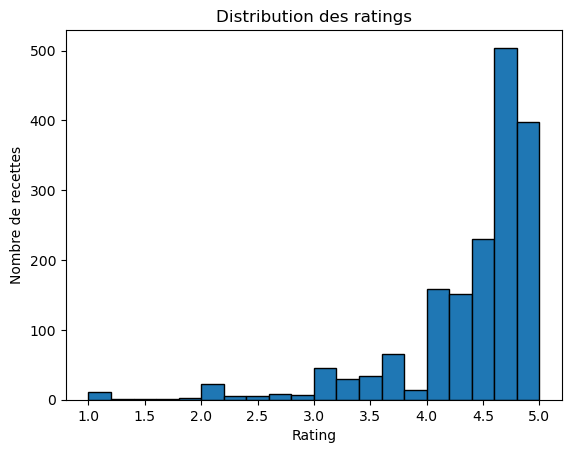

In [88]:
# Statistiques descriptives
print(df['rating'].describe())

# Proportion de 0
zero_ratio = (df['rating'] == 0).mean()
print(f"Proportion de 0 : {zero_ratio:.2%}")

# Histogramme
plt.hist(df['rating'], bins=20, edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Nombre de recettes')
plt.title('Distribution des ratings')
plt.show()

## 5. Select numeric features

In [103]:
numeric_features = [
    "total_ecv","total_kcal","total_protein","total_fat",
    "avg_ecv","avg_kcal","avg_protein","avg_fat",
    "is_vege"
]

X_num = df[numeric_features].copy()
y = df["rating"]

## 6. Normalize numeric features

In [90]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

## 7. Text embeddings (for XGBoost)

In [91]:
text_model = SentenceTransformer("all-MiniLM-L6-v2")
X_text = text_model.encode(df["title"].tolist(), show_progress_bar=True)

X_xgb = np.hstack([X_text, X_num_scaled])  # hybrid features
X_basic = X_num_scaled                    # numeric only

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

## 8. Cross-validation setup

In [92]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 9. Regression models 

## 9.1 Linear Regression

In [93]:
lr_val_mse, lr_val_r2 = [], []

for train_idx, val_idx in kf.split(X_basic):
    X_train, X_val = X_basic[train_idx], X_basic[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    preds = lr_model.predict(X_val)

    lr_val_mse.append(mean_squared_error(y_val, preds))
    lr_val_r2.append(r2_score(y_val, preds))

print("Linear Regression")
print("MSE:", np.mean(lr_val_mse), "+/-", np.std(lr_val_mse))
print("R2 :", np.mean(lr_val_r2))

Linear Regression
MSE: 0.42535946812446124 +/- 0.054253449635618546
R2 : 0.06049960599831272


## 9.2 Ridge Regression 

In [94]:
ridge_val_mse, ridge_val_r2 = [], []

for train_idx, val_idx in kf.split(X_basic):
    X_train, X_val = X_basic[train_idx], X_basic[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    preds = ridge_model.predict(X_val)

    ridge_val_mse.append(mean_squared_error(y_val, preds))
    ridge_val_r2.append(r2_score(y_val, preds))

print("Ridge Regression")
print("MSE:", np.mean(ridge_val_mse), "+/-", np.std(ridge_val_mse))
print("R2 :", np.mean(ridge_val_r2))

Ridge Regression
MSE: 0.4253018115256883 +/- 0.054044314986363806
R2 : 0.060604763444804054


## 9.3 Random Forest (numeric only)

In [95]:
rf_val_mse, rf_val_r2 = [], []

for train_idx, val_idx in kf.split(X_basic):
    X_train, X_val = X_basic[train_idx], X_basic[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42
    )

    rf_model.fit(X_train, y_train)
    preds = rf_model.predict(X_val)

    rf_val_mse.append(mean_squared_error(y_val, preds))
    rf_val_r2.append(r2_score(y_val, preds))

print("Random Forest")
print("MSE:", np.mean(rf_val_mse), "+/-", np.std(rf_val_mse))
print("R2 :", np.mean(rf_val_r2))

Random Forest
MSE: 0.45938408568697986 +/- 0.04519536935585189
R2 : -0.021082990194270224


## 9.4. XGBoost model with embeddings

In [96]:
xgb_train_mse = []
xgb_val_mse = []
xgb_train_r2 = []
xgb_val_r2 = []

for train_idx, val_idx in kf.split(X_xgb):
    X_train, X_val = X_xgb[train_idx], X_xgb[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    # Predictions
    preds_train = xgb_model.predict(X_train)
    preds_val = xgb_model.predict(X_val)

    # Metrics
    xgb_train_mse.append(mean_squared_error(y_train, preds_train))
    xgb_val_mse.append(mean_squared_error(y_val, preds_val))

    xgb_train_r2.append(r2_score(y_train, preds_train))
    xgb_val_r2.append(r2_score(y_val, preds_val))

print("XGBoost TRAIN MSE:", np.mean(xgb_train_mse))
print("XGBoost VAL   MSE:", np.mean(xgb_val_mse))
print("XGBoost TRAIN R2 :", np.mean(xgb_train_r2))
print("XGBoost VAL   R2 :", np.mean(xgb_val_r2))

XGBoost TRAIN MSE: 0.00039305238584358166
XGBoost VAL   MSE: 0.44270961039596984
XGBoost TRAIN R2 : 0.9991352095694219
XGBoost VAL   R2 : 0.01743996099440086


## 10. Cross-validation comparison plot (MSE)

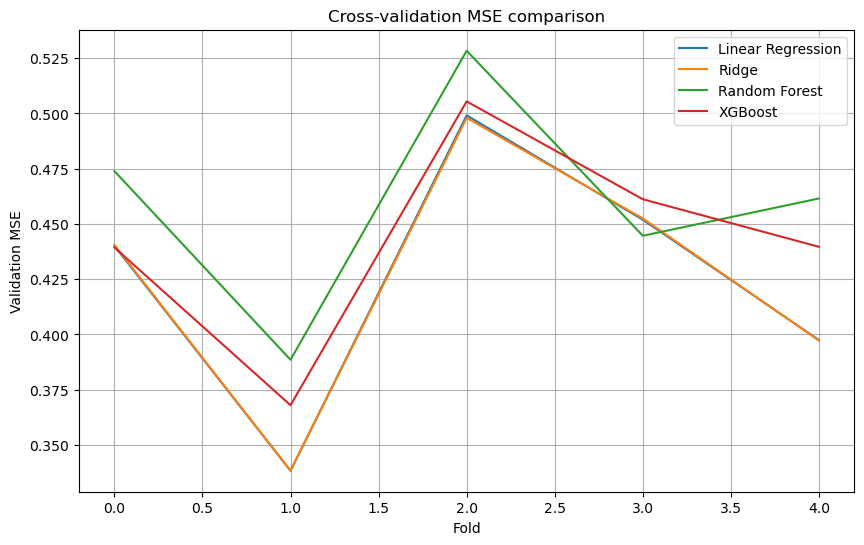

In [97]:
plt.figure(figsize=(10,6))
plt.plot(lr_val_mse, label="Linear Regression")
plt.plot(ridge_val_mse, label="Ridge")
plt.plot(rf_val_mse, label="Random Forest")
plt.plot(xgb_val_mse, label="XGBoost")

plt.xlabel("Fold")
plt.ylabel("Validation MSE")
plt.title("Cross-validation MSE comparison")
plt.legend()
plt.grid()
plt.show()

#### Plot error XGBoost train vs val

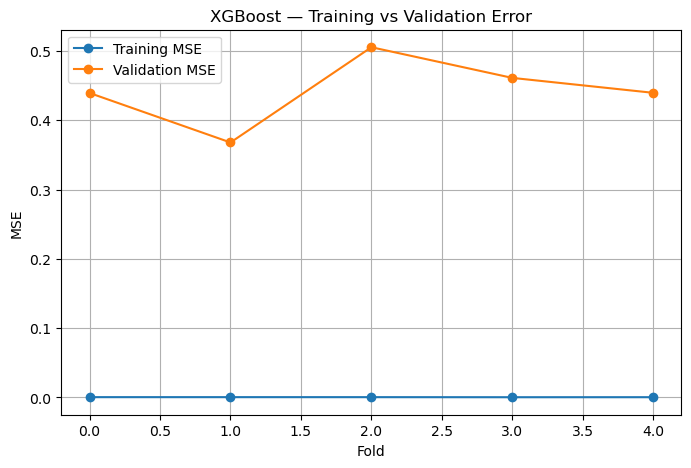

In [98]:
plt.figure(figsize=(8,5))
plt.plot(xgb_train_mse, marker="o", label="Training MSE")
plt.plot(xgb_val_mse, marker="o", label="Validation MSE")

plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("XGBoost — Training vs Validation Error")
plt.legend()
plt.grid()
plt.show()

## 11. Feature importance 

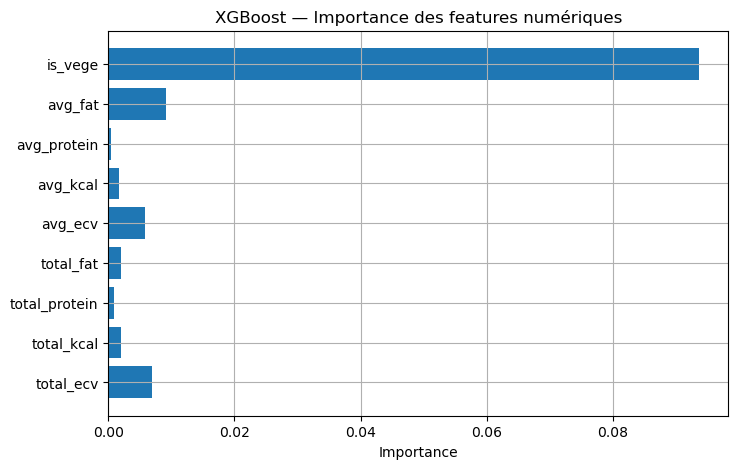

In [99]:
# Entraînement rapide pour obtenir les importances
xgb_model.fit(X_xgb, y)

importances = xgb_model.feature_importances_

# On garde uniquement les 9 dernières (numériques)
num_importances = importances[-len(numeric_features):]

plt.figure(figsize=(8,5))
plt.barh(numeric_features, num_importances)
plt.xlabel("Importance")
plt.title("XGBoost — Importance des features numériques")
plt.grid()
plt.show()

## 12. Final Model

In [100]:
# -----------------------------
# Entraînement du modèle final (sur 100 % des données)
# -----------------------------
xgb_final_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_final_model.fit(X_xgb, y)

print("Final model trained on full dataset.")

Final model trained on full dataset.


## Optional - Prediction of a new recipe

In [101]:
# -----------------------------
# Fonction de prédiction avec le modèle final
# -----------------------------
def predict_rating_xgb(title, numeric_values):
    """
    title: str
    numeric_values: list of 9 numeric features (same order as numeric_features)
    """

    # Embedding du titre
    text_vec = text_model.encode([title])

    # Normalisation des features numériques
    num_vec = scaler.transform([numeric_values])

    # Fusion
    X_new = np.hstack([text_vec, num_vec])

    # Prédiction
    return xgb_final_model.predict(X_new)[0]

Test recipe rating prediction 

In [102]:
# -----------------------------
# Exemple d'utilisation (illustratif)
# -----------------------------
example_title = "Tarte aux pommes maison"
example_features = [
    0.30,   # total_ecv
    450,    # total_kcal
    12,     # total_protein
    20,     # total_fat
    0.05,   # avg_ecv
    200,    # avg_kcal
    3,      # avg_protein
    10,     # avg_fat
    1       # is_vege
]

pred = predict_rating_xgb(example_title, example_features)
print(f"Predicted rating (illustrative): {pred:.2f}")

Predicted rating (illustrative): 3.58


/Users/gauteurmathilde/miniconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
